# MLab Onboarding Project, Fall 2023

Your task is to classify different species of birds! See the project document pinned in \#mlab-general for more details.

## Setup

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# workshop folder, e.g. 'acmlab/project'
FOLDERNAME = 'bird'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
PATH = '/content/drive/MyDrive/{}'.format(FOLDERNAME)
sys.path.append(PATH)

%cd $PATH

MessageError: ignored

In [ ]:
# Math/deep learning libraries
import numpy as np
import torch
from torch import nn

# Data processing
import pandas as pd

# Data transformations
import torchvision

# Loading images/bundles of images
from PIL import Image
import h5py

# Plotting
import matplotlib.pyplot as plt

# Progress bars
import tqdm

# Other
import time
from datetime import date

In [ ]:
# Set PyTorch to use the GPU
device = torch.device('cuda')

## Dataset

You'll need to create a way to load our training images into PyTorch.

Ordinarily, you would load images one at a time from a folder on your computer (or in our case, Google Drive). However, since Google Drive's file reading speed is extremely slow (on the order of 1 hour for the training dataset), this is inefficient for developing a model. Note that this *wouldn't* be the case if we were running locally, where file reading is much faster.

Since we still want you to get experience with creating an image dataset, we'll have you create it the traditional way (by loading images one at a time) on a **small dataset** that won't be used for actual training.

For the actual training dataset, we created an `h5py` bundle of the data, which allows you to read a single (larger) file to get a full list of images. Instead of reading the images individually, you'll be able to use the functions provided in `utils.py` to load lists of the images, labels, and classes.

### Loading images individually

Fill in the following class to load images one by one into a dataset. We provide a `csv_path` as an argument.

1. Load the CSV file using Pandas. The CSV is formatted as follows:
```
filepath,label,class
small_data/0 - GREAT XENOPS/0_1.jpg,0,GREAT XENOPS
...
small_data/2 - OSPREY/2_15.jpg,2,OSPREY
```

2. For each row of the CSV, read in the image at the `filepath`, and add the image and label to the `self.images` and `self.labels` list.

  We can load images with `Image.open(filename)`.

  We'll also want to keep track of the classes themselves, so `self.classes[0]` should equal the name of the bird with label 0 (`"GREAT XENOPS"`).

3. Fill in the rest of the functions based on the `self.images`, `self.labels`, and `self.classes` variables.

In [ ]:
class BirdDatasetSmall(torch.utils.data.Dataset):
    def __init__(self, csv_path):
        self.images = []
        self.labels = []
        self.classes = []

        ######## BEGIN YOUR CODE HERE ########

        df = pd.read_csv(csv_path)

        self.labels = df['label'].tolist()
        self.classes = [0] * (max(df['label'])+1)

        for index, row in df.iterrows():
          self.images.append(Image.open(row['filepath']))
          self.classes[row['label']] = row['class']

        ######### END YOUR CODE HERE #########

        assert len(self.images) == len(self.labels)

    def __len__(self):
        """Returns the number of examples in the dataset"""
        return len(self.images)

    def num_classes(self):
        """Returns the number of classes in the dataset"""
        return len(self.classes)

    def get_class(self, label):
        """Returns the name of the bird corresponding to the given label value"""
        return self.classes[label]

    def get_image(self, idx):
        """Returns the image of the idx'th example in the dataset"""
        return self.images[idx]

    def get_label(self, idx):
        """Returns the label of the idx'th example in the dataset"""
        return self.labels[idx]

    def __getitem__(self, idx):
        """Returns a tuple of the image and label of the idx'th example in the dataset"""
        return (self.images[idx], self.labels[idx])

    def display(self, idx):
        """Displays the image at a given index"""
        display(self.get_image(idx))

#### Testing BirdDatasetSmall

First, we'll run some basic tests to make sure the dataset is reading the right values. The first time you run this cell, it might take about a minute to load the data.

In [ ]:
def test_case(message, value, expected_value):
    print(message)
    if value == expected_value:
        print("  PASSED")
    else:
        print(f"  EXPECTED: {expected_value}")
        print(f"  GOT: {value}")

small_dataset = BirdDatasetSmall("small_data.csv")

test_case("Length of the dataset", len(small_dataset), 45)
test_case("Label of idx=17", small_dataset.get_label(17), 1)

Length of the dataset
  PASSED
Label of idx=17
  PASSED


Next, we'll display some images from the dataset. The output of running the cell should match the following image:

![](https://drive.google.com/uc?export=view&id=1mqvn-KXh8mWV6HcxulAnNqDhIPPWCq6f)

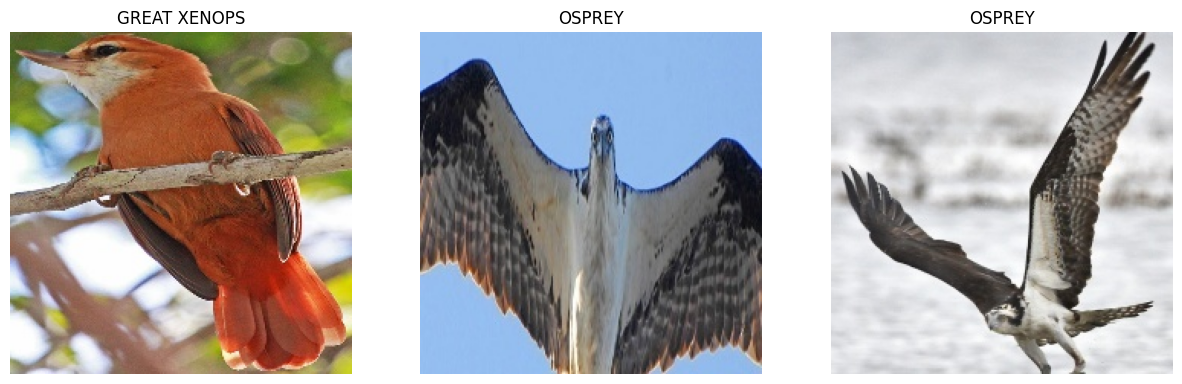

In [ ]:
# Display some images from all_data
figure = plt.figure(figsize=(15, 10))
num_rows = 1
num_cols = 3

ds_idx = [13, 30, 43]
for plot_idx, idx in enumerate(ds_idx):
    ax = plt.subplot(num_rows, num_cols, plot_idx + 1) # subplot indices begin at 1, not 0
    ax.title.set_text(small_dataset.get_class(small_dataset.get_label(idx)))
    plt.axis('off')
    plt.imshow(small_dataset.get_image(idx))

### Loading images from a bundle

As mentioned previously, for Colab performance reasons we'll be loading all the training data from a pre-created HDF5 bundle.

You'll be filling in the same code as the previous dataset, but instead of loading images one by one, you will use the `utils.load_data()` function, which returns a tuple of a list of images, a list of labels, and a list of classes.

The other difference is the inclusion of a `transform` parameter. This is a `torchvision` Transform that should be applied to each image in `__getitem__` before returning.

In [ ]:
import utils

class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.images = []
        self.labels = []
        self.classes = []
        self.transform = None

        images, labels, classes = utils.load_data()
        self.images = images
        self.labels = labels
        self.classes = classes
        self.transform = transform

        assert len(self.images) == len(self.labels)

    def __len__(self):
        """Returns the number of examples in the dataset"""
        return len(self.images)

    def num_classes(self):
        """Returns the number of classes in the dataset"""
        return len(self.classes)

    def get_class(self, label):
        """Returns the name of the bird corresponding to the given label value"""
        return self.classes[label]

    def get_image(self, idx):
        """Returns the image of the idx'th example in the dataset"""
        if self.transform is not None:
          return self.transform(self.images[idx])
        return self.images[idx]

    def get_label(self, idx):
        """Returns the label of the idx'th example in the dataset"""
        return self.labels[idx]

    def __getitem__(self, idx):
        """Returns a tuple of the *transformed* image and label of the idx'th example in the dataset"""
        return (self.get_image(idx), self.get_label(idx))

    def display(self, idx):
        """Displays the image at a given index"""
        display(self.get_image(idx))

## Creating and visualizing the dataset

First, let's create the `BirdDataset`. Be sure to pass in the transform as a parameter. We're using a `ToTensor()` transform to ensure that when PyTorch goes through the dataset, it reads the images as Tensors instead of images.

The first time you run this cell, it'll take about a minute to load the file.

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

all_data = BirdDataset(transform)

### Visualizing the data

An important part of deep learning is to understand what type of data we're working with. Here, we'll visualize some of the examples of our training set.

TypeError: ignored

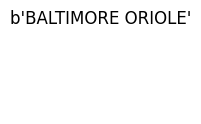

In [ ]:
# Display some images from all_data
figure = plt.figure(figsize=(15, 10))
num_rows = 8
num_cols = 8
for plot_idx in range(20):
    ax = plt.subplot(num_rows, num_cols, plot_idx + 1) # subplot indices begin at 1, not 0
    idx = (plot_idx * 373) % len(all_data)  # Gets a "random" index in the dataset

    # for this code, use `idx` as the dataset index
    cur_image = all_data.get_image(idx)
    cur_label = all_data.get_label(idx)
    cur_class = all_data.get_class(cur_label)

    ax.title.set_text(cur_class)
    plt.axis('off')
    plt.imshow(cur_image)

## Model structure

Here's where you'll define the structure of your neural network. Refer back to earlier workshop notebooks for reference.

In [ ]:

import torch.nn.functional as F

class OldModel(nn.Module):
    def __init__(self, num_classes=20):
        super().__init__()
        self.dropout = nn.Dropout(0.2)
        self.conv1 = nn.Conv2d(3, 32, 11, stride=5)
        self.pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 22, stride=1)
        self.fc1 = nn.Linear(1600, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.pool(self.pad(F.relu(self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.softmax(self.fc5(x), dim=1)
        return x

In [ ]:
# Code modified from https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class BirdModel(nn.Module):
    def __init__(self, block, layers, num_classes = 20):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

NameError: ignored

## Training setup

### Hyperparameters

Here's where we'll define our hyperparameters. We put them all in this cell for ease of readability; if you choose to add more hyperparameters, we suggest you add them here.

As you're tuning your model, change these values how you see fit!

In [ ]:
batch_size = 64
learning_rate = 0.01
num_epochs = 40

### Data Augmentation

If you choose to use data augmentation, add your augmentation transforms here.

In [ ]:
from torchvision.transforms import v2

aug = v2.Compose([
    v2.RandomHorizontalFlip(),
    v2.RandomResizedCrop(size=(224, 224), antialias=True)
])

### Data loaders

Here we'll create the data loaders for the train and validation set. To split `all_data` into the training and validation sets, read the PyTorch documentation for `random_split`: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

Be sure to pass in the `batch_size` hyperparameter to the DataLoaders, and be sure to shuffle the training data loader!

In [ ]:
from torch.utils.data import random_split, DataLoader

train_len = 2500
val_len = 613

train_set, val_set = random_split(all_data, [train_len, val_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

## Training

It's time to train our model!

### Evaluation function

First, let's create a function that evaluates the accuracy of a model on a specified dataset. We provide some of the skeleton code, but you'll be coding this one on your own!

Be sure to call `.to(device=device)` on any data tensors to make sure PyTorch is using the GPU.

In [ ]:
# split is a variable you can set as the "name" of the dataset (either "train" or "val")
def evaluate(model, data_loader, name="val"):
    correct = 0  # number of correct predictions
    total = 0    # total number of examples in the data loader

    for data in data_loader:
      inputs, labels = data[0].to(device=device).float(), data[1].to(device=device).float()
      outputs = model(inputs).to(device=device).float()
      _, out = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (out == labels).sum().item()

    print(f'Accuracy of the network on the {total} {name} images: {100 * correct / total}%')

### Training loop

This is it: this is where your model learns! You'll also be implementing this function on your own. A couple tips:
* Be sure to apply augmentations to your data if you're using them
* Be sure to call `.to(device=device)` on your model and any data tensors to make sure PyTorch is using the GPU
* Call `evaluate` on both the train and validation data loaders after each epoch

In [ ]:
model = BirdModel(ResidualBlock, [3, 4, 6, 3])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

model.to(device=device)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affin

In [ ]:

start_time = time.time()
optimizer.param_groups[0]['lr'] = 0.001
for epoch in range(num_epochs):
  for data in train_loader:
    inputs, labels = data[0].cuda().float(), data[1].cuda().float()
    inputs = aug(inputs)
    optimizer.zero_grad()
    outputs = model(inputs).cuda()
    labels = labels.long().cuda()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
  evaluate(model, train_loader, name='train')
  evaluate(model, val_loader)

end_time = time.time()
print(f"Total training time: {end_time - start_time} sec")

Accuracy of the network on the 2500 train images: 90.16%
Accuracy of the network on the 613 val images: 84.01305057096248%
Accuracy of the network on the 2500 train images: 90.16%
Accuracy of the network on the 613 val images: 83.3605220228385%
Accuracy of the network on the 2500 train images: 91.12%
Accuracy of the network on the 613 val images: 83.84991843393148%
Accuracy of the network on the 2500 train images: 91.84%
Accuracy of the network on the 613 val images: 83.6867862969005%
Accuracy of the network on the 2500 train images: 92.16%
Accuracy of the network on the 613 val images: 83.19738988580751%
Accuracy of the network on the 2500 train images: 92.36%
Accuracy of the network on the 613 val images: 84.33931484502448%


KeyboardInterrupt: ignored

### Saving model weights

Save your weights! Your final model's weights will be one component of your submission. We recommend saving weights with a recognizable name, such as the date and a short description of the structure of your model (e.g. `"2023_10_25_3LayerCNN"`)

In [ ]:
model_name = "resnet3"  ### CHANGE THIS NAME EACH TIME YOU SAVE WEIGHTS! ###

date_str = date.today().strftime("%Y_%m_%d")
model_weights_filename = f"{date_str}_{model_name}.pt"

torch.save(model.state_dict(), f"{model_weights_filename}")
print(f"Model weights saved as {model_weights_filename}")

Model weights saved as 2023_12_02_resnet3.pt


### Refining your model

Now that you've trained a basic model, it's time to see if you can improve its accuracy. Feel free to change anything – the model structure, hyperparameters, augmentation – or try employing training strategies like regularization or early stopping. Get creative!

## Predict functions

These functions will let us run the test set through your model. It is **incredibly important** that you implement these functions!

`predict` should load the image at the specified path, run it through the model (variable provided as a parameter), and output the **predicted label** (the single numerical value between 0 and 19) – *not* the class name (e.g. the name of the bird).

In [ ]:
def load_model():
    model_path = "2023_12_02_resnet3.pt"

    model = BirdModel()
    model.load_state_dict(torch.load(model_path))
    return model

In [ ]:
def predict(model, image_path):
    prediction = None

    prediction = model(torchvision.transforms.ToTensor()(Image.open(image_path)))

    return prediction